In [ ]:
import glob
import os 
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import cv2
import shutil
import tensorflow as tf

In [ ]:
tf.test.gpu_device_name ()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir=r'/content/drive/MyDrive/COVID-19_Radiography_Dataset'
classes_dir=['/NORMAL','/COVID']

In [ ]:
for classe in classes_dir:
    os.makedirs(root_dir +'/train' + classe)
    os.makedirs(root_dir +'/val' + classe)
    os.makedirs(root_dir +'/test' + classe)
    
    src = root_dir + classe

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - 0.2)), 
                                                               int(len(allFileNames)* (1 - 0.1))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'/train' + classe)

    for name in val_FileNames:
        shutil.copy(name, root_dir +'/val' + classe)
        
    for name in test_FileNames:
        shutil.copy(name, root_dir +'/test' + classe)

In [ ]:
path_train=r"/content/drive/MyDrive/COVID-19_Radiography_Dataset/train"
path_valid=r"/content/drive/MyDrive/COVID-19_Radiography_Dataset/val"
path_test=r"/content/drive/MyDrive/COVID-19_Radiography_Dataset/test"

In [ ]:
assign_dict = {"NORMAL":0, "COVID":1}
img_size = 175

In [ ]:
def get_data(directory):
    data = []
    for sub_directory in os.listdir(directory):
        if sub_directory == "NORMAL":
            inner_directory = os.path.join(directory,sub_directory)
            for i in os.listdir(inner_directory):
                img = cv2.imread(os.path.join(inner_directory,i),1)#Il spécifie de charger une image en mode niveaux de gris. Alternativement, on peut passer la valeur entière 0 pour cet indicateur.
                img = cv2.resize(img,(img_size,img_size))
                data.append([img,assign_dict[sub_directory]])  
        if sub_directory == "COVID":
            inner_directory = os.path.join(directory,sub_directory)
            for i in os.listdir(inner_directory):
                img = cv2.imread(os.path.join(inner_directory,i),1)
                img = cv2.resize(img,(img_size,img_size))
                data.append([img,assign_dict[sub_directory]])
    random.shuffle(data)  
    return np.array(data)

In [ ]:
train = get_data(path_train)
valid = get_data(path_valid)
test = get_data(path_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
total_image = 0
def data_image(directory, total_image):
    for category in os.listdir(directory):
        img_dir = os.path.join(directory, category)
        img = len(os.listdir(img_dir))
        total_image += img
        print(f"{category} : {img}")
    print("Total Image : ", total_image)

data_image(path_train,total_image)
data_image(path_valid,total_image)
data_image(path_test,total_image)

COVID : 2892
NORMAL : 2880
Total Image :  5772
NORMAL : 1019
COVID : 362
Total Image :  1381
COVID : 360
NORMAL : 500
Total Image :  860


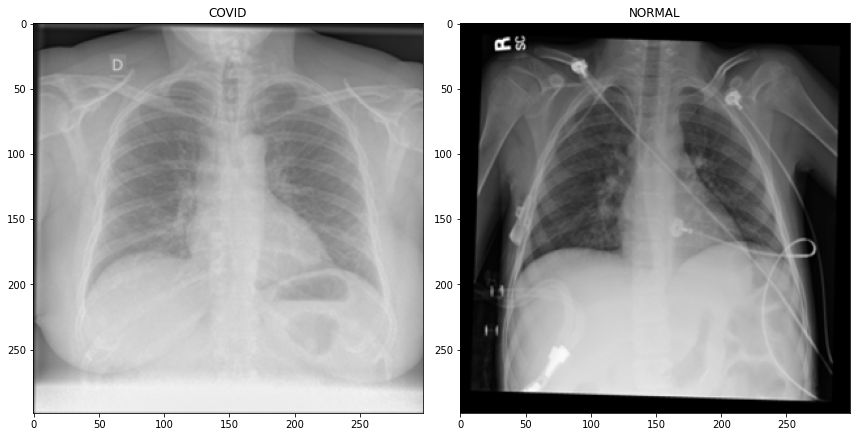

In [ ]:
import matplotlib.pyplot as plt
import os
import random

plt.figure(figsize = (12,6))
i = 1


for image in os.listdir(path_train): 
    plt.subplot(1,2,i)
    i += 1
    plt.title(str(image))
    image_folder = os.path.join(path_train, image)
    rnd_number = random.randint(0, len(os.listdir(image_folder)))
    image_file = os.listdir(image_folder)[rnd_number]
    image_file = os.path.join(image_folder, image_file)
    image_show = cv2.imread(image_file)
    plt.imshow(image_show)

plt.tight_layout()
plt.show()

In [ ]:
def preprocessing_data(L):
    X=[]; y=[]
    for features,label in L:
        X.append(features)
        y.append(label)
    X=np.array(X).reshape(-1, img_size, img_size, 3)/255
    return X,np.array(y)

In [ ]:
X_test, y_test = preprocessing_data(test)

In [ ]:
X_valid, y_valid = preprocessing_data(valid)

In [ ]:
X_train, y_train = preprocessing_data(train)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range = 20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        )  
datagen.fit(X_train)

# CNN Model

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Sequential

model_CNN = Sequential([
    #Block1
    Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', input_shape = (175,175,3)),
    MaxPooling2D((2,2) , strides = 2 , padding = 'same'),
    #Block2
    Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    MaxPooling2D((2,2) , strides = 2 , padding = 'same'),
    #Block3
    Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    MaxPooling2D((2,2) , strides = 2 , padding = 'same'),
    Dropout(0.1),
    #Block4
    Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    MaxPooling2D((2,2) , strides = 2 , padding = 'same'),
    Dropout(0.1),
    Flatten(),
    Dense(units = 128 , activation = 'relu'),
    Dense(units = 128 , activation = 'relu'),
    Dense(units = 1 , activation = 'sigmoid')
])


model_CNN.compile(optimizer = tf.keras.optimizers.Adam(lr=0.0001) , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model_CNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 175, 175, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 88, 88, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 88, 88, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 44, 44, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 44, 44, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 22, 22, 128)     

In [ ]:
history = model_CNN.fit(X_train,y_train, batch_size = 64,
                    epochs = 50 ,
                    validation_data = (X_valid, y_valid),
                    verbose=1)

Epoch 1/50
91/91 [==============================] - 445s 5s/step - loss: 0.6135 - accuracy: 0.6729 - val_loss: 0.4828 - val_accuracy: 0.7473
Epoch 2/50
91/91 [==============================] - 446s 5s/step - loss: 0.3998 - accuracy: 0.8198 - val_loss: 0.3428 - val_accuracy: 0.8523
Epoch 3/50
91/91 [==============================] - 449s 5s/step - loss: 0.2896 - accuracy: 0.8808 - val_loss: 0.2843 - val_accuracy: 0.8856
Epoch 4/50
91/91 [==============================] - 448s 5s/step - loss: 0.2548 - accuracy: 0.8999 - val_loss: 0.2575 - val_accuracy: 0.8943
Epoch 5/50
91/91 [==============================] - 447s 5s/step - loss: 0.2231 - accuracy: 0.9115 - val_loss: 0.2030 - val_accuracy: 0.9138
Epoch 6/50
91/91 [==============================] - 447s 5s/step - loss: 0.1830 - accuracy: 0.9291 - val_loss: 0.1914 - val_accuracy: 0.9269
Epoch 7/50
91/91 [==============================] - 447s 5s/step - loss: 0.1593 - accuracy: 0.9365 - val_loss: 0.2103 - val_accuracy: 0.9160
Epoch 8/50
91

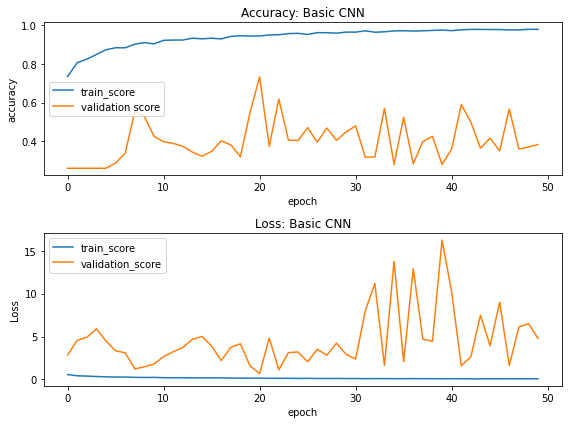

In [ ]:
fig = plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label='train_score')
plt.plot(history.history['val_accuracy'], label='validation score')
plt.title('Accuracy: Basic CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.subplot(2,1,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.title('Loss: Basic CNN')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.tight_layout()

In [ ]:
import os
save_dir = r'/content/drive/MyDrive/COVID-19_Radiography_Dataset'
model_name = 'Basic_CNN.h5'
model_path = os.path.join(save_dir, model_name)
model_CNN.save(model_path)
print('Modèle enregistré dans %s ' % model_path)

Modèle enregistré dans /content/drive/MyDrive/COVID-19_Radiography_Dataset/Basic_CNN.h5 


In [ ]:
from keras.models import load_model
model= load_model(r'/content/drive/MyDrive/COVID-19_Radiography_Dataset/Basic_CNN.h5')

In [ ]:
model.evaluate(X_test,y_test)[0]

44/44 [==============================] - 2s 34ms/step - loss: 3.4869 - accuracy: 0.5333


3.4869484901428223

# VGG-19 Model

In [ ]:
IMG_SHAPE = (175, 175, 3)

In [ ]:
from keras.applications import vgg19
base_model = vgg19.VGG19(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable=False
base_model.summary()

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable=False

In [ ]:
from keras.layers import  Dense, Flatten, Dropout
x = Flatten()(base_model.output)
hidden_1=Dense(units=2048, activation='relu')(x)
Dropout(0.4)
hidden_2=Dense(units=2048, activation='relu')(hidden_1)
Dropout(0.4)
prediction = Dense(units=1, activation='sigmoid')(hidden_2)

In [ ]:
from keras.models import Model
model_vgg = Model(inputs=base_model.input, outputs=prediction)
model_vgg.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 175, 175, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 175, 175, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 175, 175, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 87, 87, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 87, 87, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 87, 87, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 43, 43, 128)       0     

In [ ]:
history = model_vgg.fit(datagen.flow(X_train,y_train, batch_size = 64),
                    epochs = 50 ,
                    validation_data = (X_valid, y_valid),
                    verbose=1)

Epoch 1/50
91/91 [==============================] - 95s 619ms/step - loss: 0.5483 - accuracy: 0.7123 - val_loss: 0.3681 - val_accuracy: 0.8349
Epoch 2/50
91/91 [==============================] - 46s 510ms/step - loss: 0.3670 - accuracy: 0.8387 - val_loss: 0.4630 - val_accuracy: 0.7871
Epoch 3/50
91/91 [==============================] - 46s 502ms/step - loss: 0.3439 - accuracy: 0.8549 - val_loss: 0.2646 - val_accuracy: 0.8950
Epoch 4/50
91/91 [==============================] - 46s 506ms/step - loss: 0.3111 - accuracy: 0.8631 - val_loss: 0.2713 - val_accuracy: 0.8899
Epoch 5/50
91/91 [==============================] - 46s 505ms/step - loss: 0.2965 - accuracy: 0.8764 - val_loss: 0.2063 - val_accuracy: 0.9211
Epoch 6/50
91/91 [==============================] - 47s 517ms/step - loss: 0.2802 - accuracy: 0.8803 - val_loss: 0.2288 - val_accuracy: 0.9102
Epoch 7/50
91/91 [==============================] - 47s 514ms/step - loss: 0.2601 - accuracy: 0.8905 - val_loss: 0.2026 - val_accuracy: 0.9298

In [ ]:
import os
save_dir = r'/content/drive/MyDrive/COVID-19_Radiography_Dataset'
model_name = 'CNN_vgg.h5'
model_path = os.path.join(save_dir, model_name)
model_vgg.save(model_path)
print('Modèle enregistré dans %s ' % model_path)

Modèle enregistré dans /content/drive/MyDrive/COVID-19_Radiography_Dataset/CNN_vgg.h5 


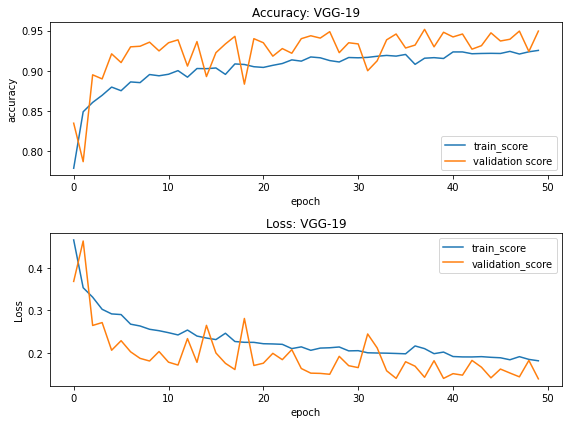

In [ ]:
fig = plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label='train_score')
plt.plot(history.history['val_accuracy'], label='validation score')
plt.title('Accuracy: VGG-19')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.subplot(2,1,2)
plt.plot(history.history['loss'], label='train_score')
plt.plot(history.history['val_loss'], label='validation_score')
plt.title('Loss: VGG-19')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.tight_layout()

In [ ]:
from keras.models import load_model
model_vgg= load_model(r'/content/drive/MyDrive/COVID-19_Radiography_Dataset/CNN_vgg.h5')

In [ ]:
model_vgg.evaluate(X_test,y_test)


27/27 [==============================] - 177s 7s/step - loss: 0.1867 - accuracy: 0.9372


[0.18665321171283722, 0.9372093081474304]

# VGG-19 model with training last layers

In [ ]:
model_vgg_trainable = model_vgg

In [ ]:
import pandas as pd
pd.set_option('display.max_rows',177)
layers = [(layer, layer.name, layer.trainable) for layer in model_vgg_trainable.layers]

In [ ]:
model_vgg_trainable.trainable = True

set_trainable = False
for layer in model_vgg_trainable.layers:
    if (('block3') in layer.name) or (('block4') in layer.name) or (('block5') in layer.name) :
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in model_vgg_trainable.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_1,False
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,True
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,True
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,True


In [ ]:
history = model_vgg_trainable.fit(datagen.flow(X_train,y_train, batch_size = 64),
                    epochs = 50 ,
                    validation_data = (X_valid, y_valid),
                    verbose=1)

Epoch 1/50
91/91 [==============================] - 89s 559ms/step - loss: 1.4820 - accuracy: 0.7107 - val_loss: 0.5352 - val_accuracy: 0.7625
Epoch 2/50
91/91 [==============================] - 41s 448ms/step - loss: 0.3425 - accuracy: 0.8562 - val_loss: 0.2628 - val_accuracy: 0.8979
Epoch 3/50
91/91 [==============================] - 41s 445ms/step - loss: 0.3124 - accuracy: 0.8646 - val_loss: 0.1772 - val_accuracy: 0.9319
Epoch 4/50
91/91 [==============================] - 41s 446ms/step - loss: 0.2679 - accuracy: 0.8825 - val_loss: 0.6366 - val_accuracy: 0.7531
Epoch 5/50
91/91 [==============================] - 41s 448ms/step - loss: 0.3319 - accuracy: 0.8526 - val_loss: 0.2061 - val_accuracy: 0.9225
Epoch 6/50
91/91 [==============================] - 41s 445ms/step - loss: 0.2701 - accuracy: 0.8897 - val_loss: 0.1770 - val_accuracy: 0.9298
Epoch 7/50
91/91 [==============================] - 40s 444ms/step - loss: 0.2714 - accuracy: 0.8828 - val_loss: 0.1722 - val_accuracy: 0.9435

In [ ]:
import os
save_dir = r'/content/drive/MyDrive/COVID-19_Radiography_Dataset'
model_name = 'CNN_vgg_trainable.h5'
model_path = os.path.join(save_dir, model_name)
model_vgg_trainable.save(model_path)
print('Modèle enregistré dans %s ' % model_path)

Modèle enregistré dans /content/drive/MyDrive/COVID-19_Radiography_Dataset/CNN_vgg_trainable.h5 


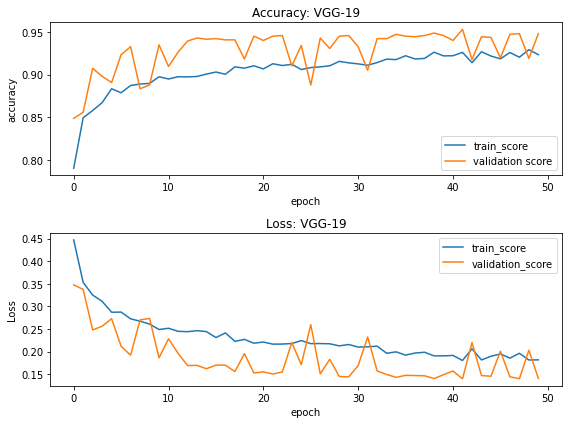

In [ ]:
fig = plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label='train_score')
plt.plot(history.history['val_accuracy'], label='validation score')
plt.title('Accuracy: VGG-19')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.subplot(2,1,2)
plt.plot(history.history['loss'], label='train_score')
plt.plot(history.history['val_loss'], label='validation_score')
plt.title('Loss: VGG-19')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.tight_layout()

In [ ]:
 model_vgg_trainable.evaluate(X_test,y_test)

27/27 [==============================] - 3s 103ms/step - loss: 0.1617 - accuracy: 0.9430


[0.1617342084646225, 0.9430232644081116]

# ResNet-50 Model

In [ ]:
from keras.applications import ResNet50
base_model = ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable=False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 175, 175, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 181, 181, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 88, 88, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 88, 88, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
base_model.output

<KerasTensor: shape=(None, 6, 6, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [ ]:
from keras.layers import  Dense, Flatten
x = Flatten()(base_model.output)
prediction = Dense(units=1, activation='sigmoid')(x)

In [ ]:
from keras.models import Model
model_Resnet = Model(inputs=base_model.input, outputs=prediction)
model_Resnet.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [ ]:
history = model_Resnet.fit(datagen.flow(X_train,y_train, batch_size = 64),
                    epochs = 50 ,
                    validation_data = (X_valid, y_valid),
                    verbose=1)

Epoch 1/50
91/91 [==============================] - 78s 466ms/step - loss: 0.8365 - accuracy: 0.6035 - val_loss: 0.5412 - val_accuracy: 0.7154
Epoch 2/50
91/91 [==============================] - 38s 413ms/step - loss: 0.5848 - accuracy: 0.7090 - val_loss: 0.5023 - val_accuracy: 0.7422
Epoch 3/50
91/91 [==============================] - 38s 419ms/step - loss: 0.5301 - accuracy: 0.7403 - val_loss: 0.6828 - val_accuracy: 0.6517
Epoch 4/50
91/91 [==============================] - 38s 416ms/step - loss: 0.5275 - accuracy: 0.7429 - val_loss: 0.6260 - val_accuracy: 0.6807
Epoch 5/50
91/91 [==============================] - 38s 412ms/step - loss: 0.5373 - accuracy: 0.7379 - val_loss: 0.5663 - val_accuracy: 0.7089
Epoch 6/50
91/91 [==============================] - 38s 415ms/step - loss: 0.4889 - accuracy: 0.7571 - val_loss: 0.4092 - val_accuracy: 0.7951
Epoch 7/50
91/91 [==============================] - 38s 417ms/step - loss: 0.5063 - accuracy: 0.7490 - val_loss: 0.4602 - val_accuracy: 0.7581

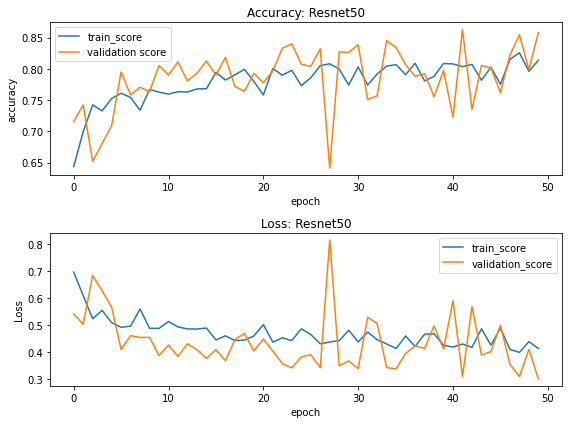

In [ ]:
fig = plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label='train_score')
plt.plot(history.history['val_accuracy'], label='validation score')
plt.title('Accuracy: Resnet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.subplot(2,1,2)
plt.plot(history.history['loss'], label='train_score')
plt.plot(history.history['val_loss'], label='validation_score')
plt.title('Loss: Resnet50')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.tight_layout()

In [ ]:
import os
save_dir = r'/content/drive/MyDrive/COVID-19_Radiography_Dataset'
model_name = 'CNN_Resnet_Untrainable.h5'
model_path = os.path.join(save_dir, model_name)
model_Resnet.save(model_path)
print('Modèle enregistré dans %s ' % model_path)

Modèle enregistré dans /content/drive/MyDrive/COVID-19_Radiography_Dataset/CNN_Resnet_Untrainable.h5 


In [ ]:
from keras.models import load_model
model= load_model(r'/content/drive/MyDrive/COVID-19_Radiography_Dataset/CNN_Resnet_Untrainable.h5')

In [ ]:
model_Resnet.evaluate(X_test,y_test)[0]

27/27 [==============================] - 4s 80ms/step - loss: 0.3650 - accuracy: 0.8395


0.3649560213088989